## Earthquake AI - Modelling

Loading and splitting data …
Data ready.

Model: LGBMClassifier
Train accuracy:0.5835
Confusion matrix:
[[ 750  334  155    0]
 [ 167 1517  987   25]
 [  22  476  964    9]
 [   0  101   60   42]]


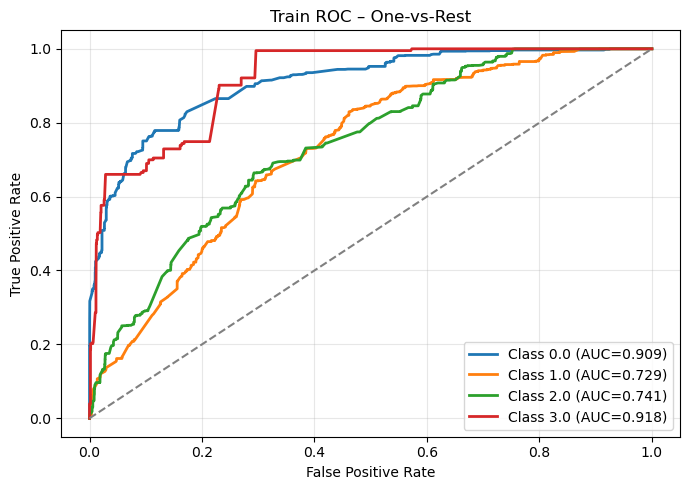

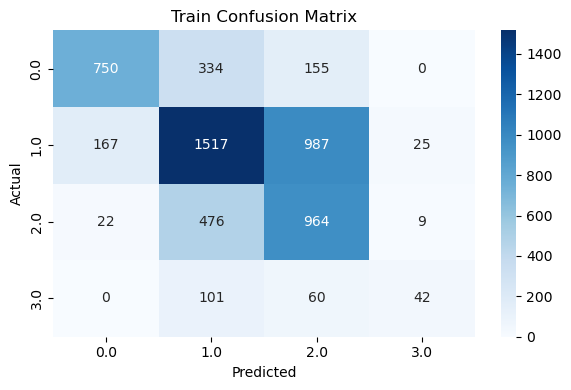


Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.61      0.69      1239
         1.0       0.62      0.56      0.59      2696
         2.0       0.45      0.66      0.53      1471
         3.0       0.55      0.21      0.30       203

    accuracy                           0.58      5609
   macro avg       0.61      0.51      0.53      5609
weighted avg       0.61      0.58      0.59      5609

Test accuracy:0.5865
Confusion matrix:
[[191  52   4   7]
 [ 79 467 123  12]
 [  0  89  91   4]
 [  0  95  63   0]]


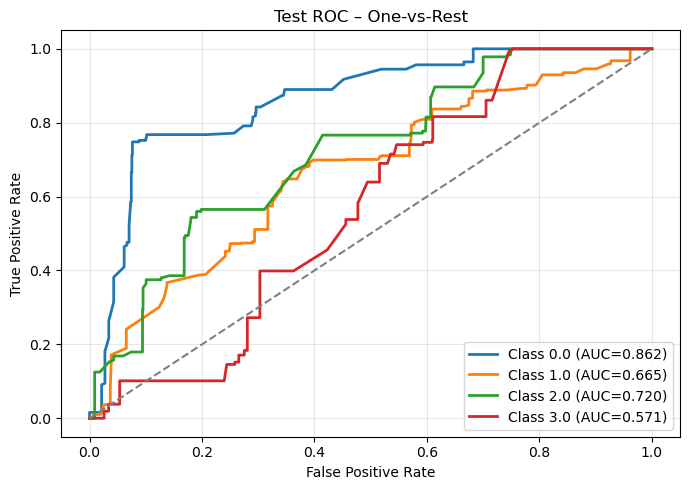

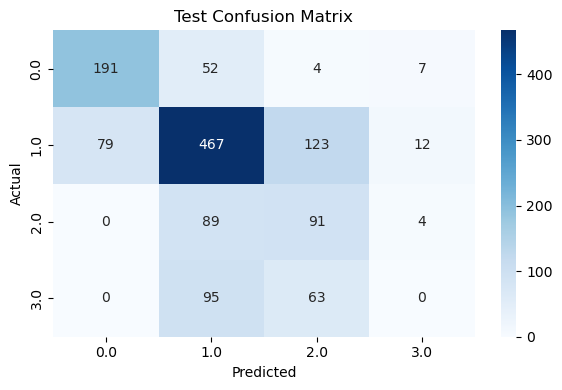


Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.75      0.73       254
         1.0       0.66      0.69      0.67       681
         2.0       0.32      0.49      0.39       184
         3.0       0.00      0.00      0.00       158

    accuracy                           0.59      1277
   macro avg       0.42      0.48      0.45      1277
weighted avg       0.54      0.59      0.56      1277

SHAP exposition …


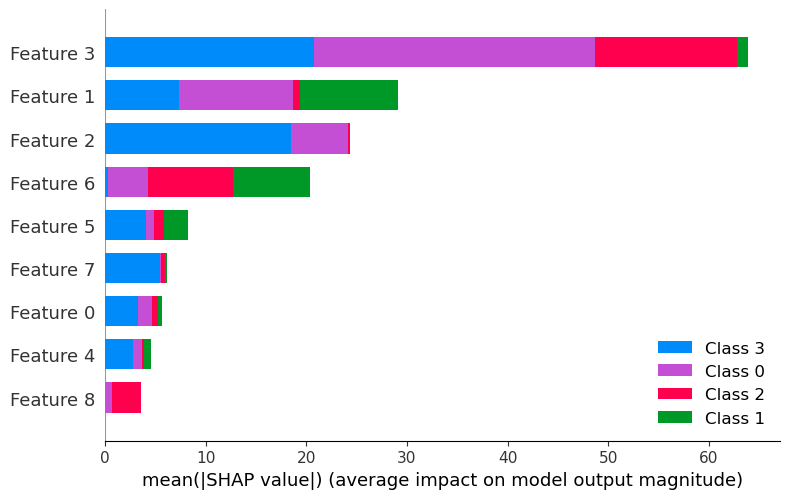

In [46]:
# ----------------------------------------------------------
# 0. Imports
# ----------------------------------------------------------
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
import shap                                      # Explainability

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             accuracy_score, confusion_matrix, roc_auc_score,
                             classification_report, roc_curve, auc)

# ------------------ Model Imports ------------------
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


# ----------------------------------------------------------
# 1. Data utilities
# ----------------------------------------------------------
def load_and_split_data(path: str, task: str):
    """
    Load the dataset, clean it, and perform a temporal train–test split.
    Returns X_train, X_test, y_train, y_test.
    """
    print("Loading and splitting data …")
    df = pd.read_parquet(path).drop(columns=["magnitudes_list"])
    df["date"] = pd.to_datetime(df["date"])
    df.drop(columns=["daily_max_30d_mean"], inplace=True)

    target = "max_mag_next_30d" if task == "regression" else "target_class"
    df = df.dropna(subset=[target])
    X, y = df.drop(columns=["max_mag_next_30d", "target_class"]), df[target]

    if task == "classification":
        y = y - 1            # shift labels to start at 0
        y = y >= 3           # bool → two classes (False / True)

    # # ---- project-specific: collapse to binary “≥3” vs “<3” -------------
    # if task == "classification":
    #     y = y >= 3           # bool → two classes (False / True)

    # ---- temporal split -----------------------------------------------
    X_train = X.loc[X.date <  "2024-01-01"].copy()
    X_test  = X.loc[X.date >= "2024-01-30"].copy()
    y_train = y.loc[X.date <  "2024-01-01"].copy()
    y_test  = y.loc[X.date >= "2024-01-30"].copy()

    # keep only labels appearing in both splits
    common = set(y_train.unique()) & set(y_test.unique())
    mask_tr = y_train.isin(common)
    mask_te = y_test.isin(common)
    X_train, y_train = X_train.loc[mask_tr].drop(columns=["date"]), y_train[mask_tr]
    X_test,  y_test  = X_test.loc[mask_te].drop(columns=["date"]),  y_test[mask_te]

    print("Data ready.")
    return X_train, X_test, y_train, y_test


def build_preprocessor():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ])


# ----------------------------------------------------------
# 2. Model factory  (unchanged)
# ----------------------------------------------------------
def get_model_and_param_grid(model_name: str, task: str, y_train=None):
    # ------------- add / adjust models as needed -------------
    if task == "regression":
        if model_name == "XGBRegressor":
            model = XGBRegressor(
                n_estimators=1_000, learning_rate=0.01, max_depth=3,
                min_child_weight=10, gamma=0.5, subsample=0.7,
                colsample_bytree=0.7, reg_lambda=10, reg_alpha=1,
                random_state=42
            )
            param_grid = {"model__max_depth":[3,5],
                          "model__learning_rate":[0.01,0.05],
                          "model__min_child_weight":[10,20]}
        else:
            model, param_grid = LinearRegression(), {}
    else:  # classification
        if model_name == "LGBMClassifier":
            model = LGBMClassifier(
                num_leaves=10, max_depth=2, min_child_samples=50,
                colsample_bytree=0.7, subsample=0.7,
                learning_rate=0.01, n_estimators=50, boosting_type="rf",
                reg_alpha=0.8, reg_lambda=0.8, cat_smooth=10,
                is_unbalance=True, random_state=42, verbose=-1
            )
            param_grid = {"model__num_leaves":[15,31,50],
                          "model__learning_rate":[0.005,0.01,0.05]}
        else:
            model, param_grid = LogisticRegression(max_iter=1_000), {"model__C":[0.1,1,10]}
    return model, param_grid


# ----------------------------------------------------------
# 3-a. Post-hoc threshold logic
# ----------------------------------------------------------
def predict_with_thresholds(pipe, X, thresholds=None, default_rule="argmax"):
    """
    Force a prediction to class k whenever proba[k] ≥ τ_k.
    """
    if not thresholds:
        return pipe.predict(X)

    proba   = pipe.predict_proba(X)
    classes = pipe.named_steps["model"].classes_
    idx_map = {c:i for i,c in enumerate(classes)}

    preds = np.argmax(proba, axis=1) if default_rule=="argmax" \
            else np.full(len(X), -1)

    for cls, τ in thresholds.items():
        if cls not in idx_map: continue
        preds[proba[:, idx_map[cls]] >= τ] = cls
    return preds


# ----------------------------------------------------------
# 3-b.  Plotting & evaluation  (ROC now handles 2 or >2 classes)
# ----------------------------------------------------------
def plot_roc_auc(pipe, X, y, dataset):
    """
    Draw a single ROC curve for binary problems, or
    One-vs-Rest curves for multi-class.
    """
    if not hasattr(pipe.named_steps["model"], "predict_proba"):
        print("Model lacks predict_proba – skipping ROC curves.")
        return

    y_score = pipe.predict_proba(X)
    classes = pipe.named_steps["model"].classes_

    plt.figure(figsize=(7, 5))
    if len(classes) == 2:
        pos_proba = y_score[:, 1]          # column 1 → positive class
        fpr, tpr, _ = roc_curve(y, pos_proba)
        plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC={auc(fpr,tpr):.3f})")
        plt.title(f"{dataset} ROC curve (binary)")
    else:
        y_bin = label_binarize(y, classes=classes)
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
            plt.plot(fpr, tpr, lw=2, label=f"Class {cls} (AUC={auc(fpr,tpr):.3f})")
        plt.title(f"{dataset} ROC – One-vs-Rest")

    plt.plot([0,1],[0,1],"--",color="gray")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


def evaluate_regression(pipe, X, y, dataset):
    y_pred = pipe.predict(X)
    print(f"{dataset} → MSE:{mean_squared_error(y,y_pred):.4f} | "
          f"MAE:{mean_absolute_error(y,y_pred):.4f} | "
          f"R²:{r2_score(y,y_pred):.4f}")


def evaluate_classification(pipe, X, y, dataset, thresholds=None):
    y_pred  = predict_with_thresholds(pipe, X, thresholds)
    acc     = accuracy_score(y, y_pred)
    cm      = confusion_matrix(y, y_pred)

    print(f"{dataset} accuracy:{acc:.4f}\nConfusion matrix:\n{cm}")
    plot_roc_auc(pipe, X, y, dataset)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f"{dataset} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout(); plt.show()

    print("\nClassification Report:")
    print(classification_report(y, y_pred))


def plot_shap_values(pipe, X, model_name):
    tree = pipe.named_steps["model"]
    X_trans = pipe.named_steps["preprocessor"].transform(X)
    explainer = shap.TreeExplainer(tree)
    shap.summary_plot(explainer.shap_values(X_trans),
                      X_trans, plot_type="bar", max_display=10, show=True)


# ----------------------------------------------------------
# 4. Run-level parameters
# ----------------------------------------------------------
task        = "classification"     # "regression" or "classification"
do_tuning   = False
models_to_run = ["LGBMClassifier"] if task=="classification" else ["XGBRegressor"]

# ---- Optional post-hoc probability thresholds --------
apply_thresholds = True
class_thresholds = {2: 0.30, 3: 0.25}       # example for multi-class use-case


# ----------------------------------------------------------
# 5. Pipeline run
# ----------------------------------------------------------
X_train, X_test, y_train, y_test = load_and_split_data(
    "data/features/earthquake_features.parquet", task
)

# drop sparse / list columns
drop_cols = list(X_train.columns[X_train.isna().mean() >= 0.5]) \
          + [c for c in X_train.columns if "list" in c]
X_train.drop(columns=drop_cols, inplace=True)
X_test.drop(columns=drop_cols, inplace=True)

# keep top-10 features
top_10 = [
    "time_since_class_4","time_since_class_3","rolling_T_value",
    "daily_count_30d_sum","daily_b_value","rolling_dE_half",
    "daily_etas_intensity","time_since_class_2","daily_count_7d_sum"
]
X_train, X_test = X_train[top_10], X_test[top_10]

preprocessor = build_preprocessor()
cv_split     = TimeSeriesSplit(n_splits=3)

for mdl in models_to_run:
    print("\n"+"="*75)
    print(f"Model: {mdl}")

    model, param_grid = get_model_and_param_grid(mdl, task, y_train)
    pipe = Pipeline([("preprocessor", preprocessor), ("model", model)])

    if do_tuning and param_grid:
        search = RandomizedSearchCV(
            pipe, param_distributions=param_grid, cv=cv_split,
            scoring="accuracy" if task=="classification" else "r2",
            n_iter=50, random_state=42, n_jobs=-1, verbose=2
        ).fit(X_train, y_train)
        pipe = search.best_estimator_
        print("Best params:", search.best_params_)
    else:
        pipe.fit(X_train, y_train)

    thresh = class_thresholds if (apply_thresholds and task=="classification") else None

    if task == "regression":
        evaluate_regression(pipe, X_train, y_train, "Train")
        evaluate_regression(pipe, X_test,  y_test,  "Test")
    else:
        evaluate_classification(pipe, X_train, y_train, "Train", thresholds=thresh)
        evaluate_classification(pipe, X_test,  y_test,  "Test",  thresholds=thresh)

    print("SHAP exposition …")
    plot_shap_values(pipe, X_train, mdl)
    print("="*75+"\n")


In [43]:
X_train

,time_since_class_4,time_since_class_3,rolling_T_value,daily_count_30d_sum,daily_b_value,rolling_dE_half,daily_etas_intensity,time_since_class_2,daily_count_7d_sum
0,0.0,0,NaN,NaN,NaN,NaN,0.010000,0,NaN
1,0.0,0,NaN,NaN,NaN,NaN,0.010001,1,NaN
2,0.0,0,NaN,NaN,NaN,NaN,0.010000,2,NaN
3,0.0,0,NaN,NaN,NaN,NaN,0.010000,3,NaN
4,0.0,0,NaN,NaN,12.792068,NaN,0.010000,4,NaN
...,...,...,...,...,...,...,...,...,...
6903,830.0,22,130.616709,20.0,4.137612,1.298742e+07,0.011219,22,1.0
6904,831.0,23,135.816461,20.0,4.137612,1.247603e+07,0.011206,23,1.0
6905,832.0,24,135.816461,20.0,4.167567,1.247603e+07,0.011193,24,2.0
6906,833.0,25,137.862156,19.0,4.585852,1.231565e+07,0.011182,25,4.0


## Undersampling matching

In [49]:
# ----------------------------------------------------------
# 0. Imports
# ----------------------------------------------------------
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
import shap                                      # Explainability

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             accuracy_score, confusion_matrix, roc_auc_score,
                             classification_report, roc_curve, auc)

from gurobipy import Model, GRB, quicksum        # ⇠ NEW (Gurobi)

# ------------------ Model Imports ------------------
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression


# ----------------------------------------------------------
# 1. Data utilities
# ----------------------------------------------------------
def load_and_split_data(path: str):
    """
    Load the dataset, collapse to binary label (≥3 vs <3),
    and perform a temporal train–test split.
    """
    print("Loading and splitting data …")
    df = pd.read_parquet(path).drop(columns=["magnitudes_list"])
    df["date"] = pd.to_datetime(df["date"])
    df.drop(columns=["daily_max_30d_mean"], inplace=True)

    X = df.drop(columns=["max_mag_next_30d", "target_class"])
    y = df["target_class"] - 1                      # shift to 0-based
    y = (y >= 3).astype(int)                       # binary: 1 if ≥3

    # temporal split
    X_train = X.loc[X.date <  "2024-01-01"].copy()
    X_test  = X.loc[X.date >= "2024-01-30"].copy()
    y_train = y.loc[X.date <  "2024-01-01"].copy()
    y_test  = y.loc[X.date >= "2024-01-30"].copy()

    # drop date col
    X_train.drop(columns=["date"], inplace=True)
    X_test.drop(columns=["date"], inplace=True)

    print("Data ready.")
    return X_train, X_test, y_train, y_test


# ----------------------------------------------------------
# 2.  Gurobi matching undersampler  ⇢ NEW
# ----------------------------------------------------------
def gurobi_match_positives(X_pos: np.ndarray,
                           X_neg: np.ndarray) -> np.ndarray:
    """
    Solve the 1-to-(≤1) bipartite matching problem:

        min Σ_i Σ_j  z_ij ||x_i - x_j||²
        s.t.  Σ_j z_ij = 1          ∀ i (positive)
              Σ_i z_ij ≤ 1          ∀ j (negative)
              z_ij ∈ {0,1}

    Returns an array of selected negative indices (relative to X_neg).
    """
    n_pos, n_neg = X_pos.shape[0], X_neg.shape[0]
    # pre-compute squared euclidean distances
    D = np.sum((X_pos[:, None, :] - X_neg[None, :, :])**2, axis=2)

    m = Model("matching")
    m.setParam("OutputFlag", 0)

    z = m.addVars(n_pos, n_neg, vtype=GRB.BINARY, name="z")

    # objective
    m.setObjective(quicksum(D[i, j] * z[i, j]
                            for i in range(n_pos)
                            for j in range(n_neg)), GRB.MINIMIZE)

    # constraints
    for i in range(n_pos):
        m.addConstr(quicksum(z[i, j] for j in range(n_neg)) == 1)

    for j in range(n_neg):
        m.addConstr(quicksum(z[i, j] for i in range(n_pos)) <= 1)

    m.optimize()

    matched_neg = [j for i in range(n_pos) for j in range(n_neg)
                   if z[i, j].X > 0.5]
    return np.array(matched_neg, dtype=int)


def undersample_by_matching(X_train, y_train, feature_subset=None):
    """
    Keep all positives; pick a 1-for-1 set of matched negatives.
    """
    pos_idx = np.where(y_train == 1)[0]
    neg_idx = np.where(y_train == 0)[0]

    if len(pos_idx) == 0 or len(neg_idx) == 0:
        print("Matching skipped – need both classes present.")
        return X_train, y_train

    feats = feature_subset if feature_subset is not None else X_train.columns
    scaler = StandardScaler().fit(X_train[feats])    # standardise distances
    Xp = scaler.transform(X_train.iloc[pos_idx][feats])
    Xn = scaler.transform(X_train.iloc[neg_idx][feats])

    print(f"Matching {len(pos_idx)} positives to {len(neg_idx)} negatives …")
    sel_neg_rel = gurobi_match_positives(Xp, Xn)     # relative to neg_idx
    sel_neg_abs = neg_idx[sel_neg_rel]

    keep_idx = np.concatenate([pos_idx, sel_neg_abs])
    print(f"→ retained {len(keep_idx)} samples "
          f"({len(pos_idx)} pos + {len(sel_neg_abs)} neg)")

    return X_train.iloc[keep_idx].reset_index(drop=True), \
           y_train.iloc[keep_idx].reset_index(drop=True)


# ----------------------------------------------------------
# 3. Model factory
# ----------------------------------------------------------
def get_model_and_param_grid(model_name: str):
    if model_name == "LGBMClassifier":
        model = LGBMClassifier(
            num_leaves=10, max_depth=2, min_child_samples=50,
            colsample_bytree=0.7, subsample=0.7,
            learning_rate=0.01, n_estimators=50, boosting_type="rf",
            reg_alpha=0.8, reg_lambda=0.8, cat_smooth=10,
            is_unbalance=True, random_state=42, verbose=-1
        )
        param_grid = {}
    else:
        model, param_grid = LogisticRegression(max_iter=1_000), {}
    return model, param_grid


# ----------------------------------------------------------
# 4. Post-hoc threshold logic & evaluation helpers (unchanged)
# ----------------------------------------------------------
def predict_with_thresholds(pipe, X, thresholds=None):
    if not thresholds:
        return pipe.predict(X)
    proba = pipe.predict_proba(X)[:, 1]          # positive prob
    preds = (proba >= thresholds.get(1, 0.5)).astype(int)
    return preds


def plot_roc_auc(pipe, X, y, dataset):
    y_score = pipe.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_score)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, lw=2, label=f"AUC={auc(fpr,tpr):.3f}")
    plt.plot([0,1],[0,1],"--",color="grey")
    plt.title(f"{dataset} ROC")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid(); plt.show()


def evaluate_binary(pipe, X, y, dataset, thresh=None):
    preds = predict_with_thresholds(pipe, X, thresh)
    acc   = accuracy_score(y, preds)
    cm    = confusion_matrix(y, preds)
    print(f"{dataset} accuracy: {acc:.4f}\nCM:\n{cm}")
    plot_roc_auc(pipe, X, y, dataset)
    print(classification_report(y, preds))


# ----------------------------------------------------------
# 5. Run parameters
# ----------------------------------------------------------
undersampling_matching = True              # ⇠ NEW switch
models_to_run = ["LGBMClassifier"]
thresholds = None                          # e.g. {1: 0.3}


# ----------------------------------------------------------
# 6. Pipeline
# ----------------------------------------------------------
X_train, X_test, y_train, y_test = load_and_split_data(
    "data/features/earthquake_features.parquet"
)

# drop sparse / list cols
drop_cols = list(X_train.columns[X_train.isna().mean() >= 0.5]) \
          + [c for c in X_train.columns if "list" in c]
X_train.drop(columns=drop_cols, inplace=True)
X_test.drop(columns=drop_cols, inplace=True)

# top-k features (optional)
top_feats = [
    "time_since_class_4","time_since_class_3","rolling_T_value",
    "daily_count_30d_sum","daily_b_value","rolling_dE_half",
    "daily_etas_intensity","time_since_class_2","daily_count_7d_sum"
]
X_train, X_test = X_train[top_feats], X_test[top_feats]

# ----- undersample by matching ---------------------------------
if undersampling_matching:
    X_train, y_train = undersample_by_matching(X_train, y_train,
                                               feature_subset=top_feats)

preprocessor = Pipeline([("imputer", SimpleImputer(strategy="median")),
                         ("scaler",  StandardScaler())])

for mdl in models_to_run:
    print("\n"+"="*70);   print(mdl)
    model, _ = get_model_and_param_grid(mdl)
    pipe = Pipeline([("prep", preprocessor), ("clf", model)]).fit(X_train, y_train)

    evaluate_binary(pipe, X_train, y_train, "Train", thresholds)
    evaluate_binary(pipe, X_test,  y_test,  "Test",  thresholds)

    # SHAP
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(preprocessor.transform(X_train))
    shap.summary_plot(shap_vals, X_train, plot_type="bar", max_display=10)

Loading and splitting data …
Data ready.
Matching 203 positives to 5625 negatives …
Set parameter Username


GurobiError: HostID mismatch (licensed to da79ea45, hostid is ea9126d5)

## (Old) Focal Loss code

Loading and splitting data...
Data loading complete.
Building preprocessor pipeline...
Number of classes: 2
Accuracy: 0.6332312404287902
Confusion Matrix:
[[754 365]
 [114  73]]
Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.67      0.76      1119
        True       0.17      0.39      0.23       187

    accuracy                           0.63      1306
   macro avg       0.52      0.53      0.50      1306
weighted avg       0.77      0.63      0.68      1306



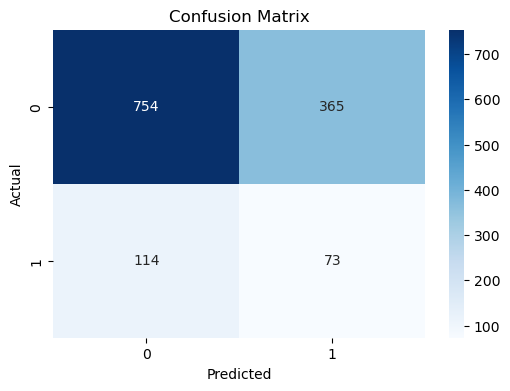

<Figure size 640x480 with 0 Axes>

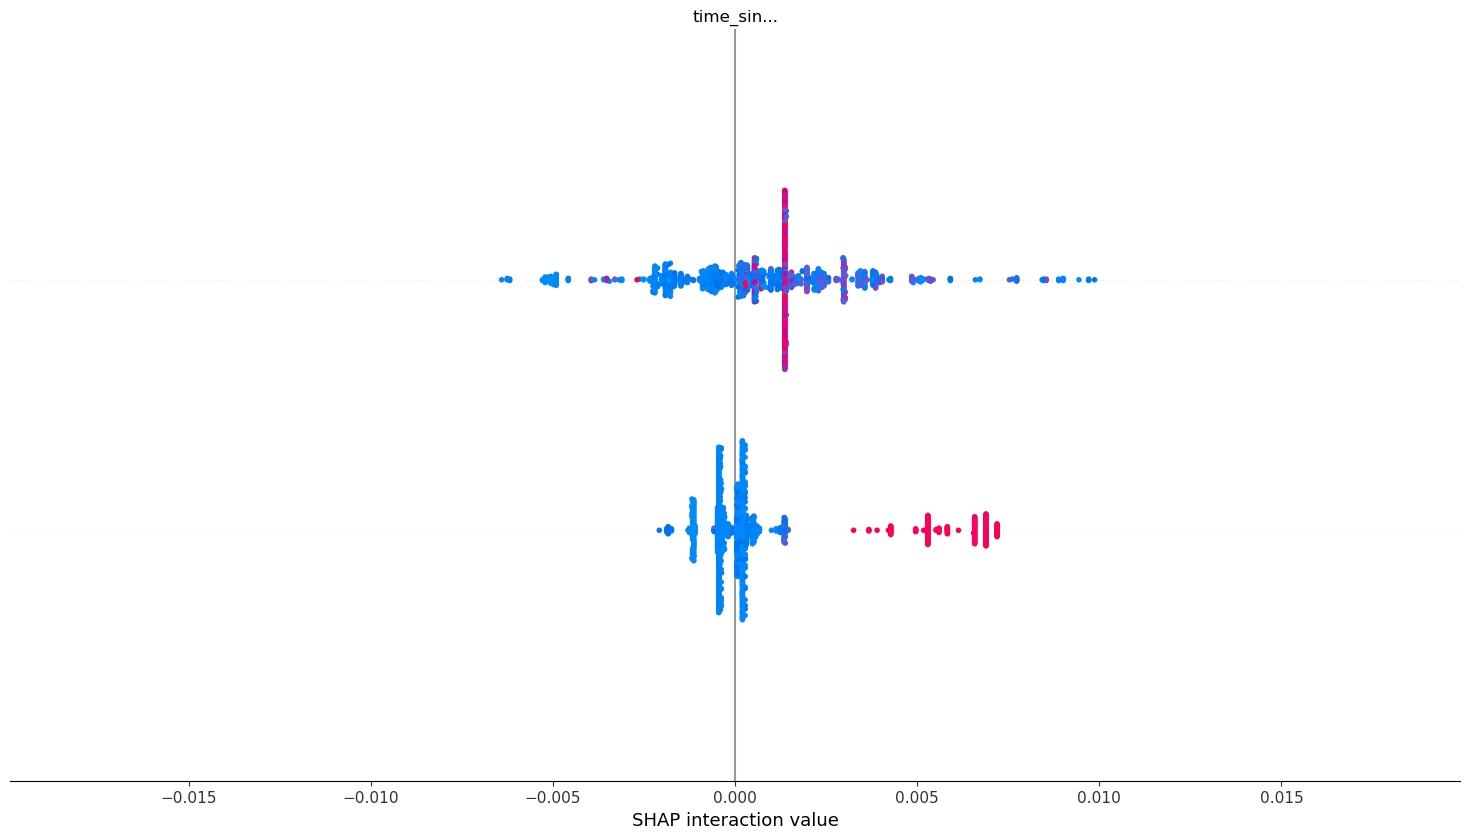

In [40]:
import pandas as pd
import numpy as np
import warnings

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

warnings.filterwarnings("ignore")

# ------------------ Custom Multiclass Focal Loss Functions ------------------
from scipy.misc import derivative

def focal_loss_lgb_multiclass(y_pred, dtrain, alpha, gamma):
    """
    Custom multiclass focal loss objective for LightGBM.
    Uses numerical finite differences to approximate gradients and Hessians.
    
    Parameters:
      y_pred: flat array of raw predictions (logits) of shape (n_samples * num_class,)
      dtrain: LightGBM Dataset, from which true labels are extracted via dtrain.get_label()
      alpha: weighting factor (e.g. 0.25)
      gamma: focusing parameter (e.g. 1)
      
    Returns:
      grad: flattened gradients (n_samples * num_class,)
      hess: flattened Hessians (n_samples * num_class,)
    """
    # Determine number of classes from the true labels.
    y_true = dtrain.get_label().astype(int)
    num_class = int(np.max(y_true)) + 1
    n_samples = dtrain.num_data()
    
    # Reshape predictions to (n_samples, num_class)
    y_pred = y_pred.reshape(n_samples, num_class)
    
    # Initialize gradient and hessian arrays
    grad = np.zeros_like(y_pred)
    hess = np.zeros_like(y_pred)
    eps = 1e-6  # finite difference step
    
    # For each sample, approximate partial derivatives for each class score
    for i in range(n_samples):
        for k in range(num_class):
            # Define a scalar function f that perturbs the k-th logit only
            def f(z):
                z_vec = y_pred[i].copy()
                z_vec[k] = z
                # Compute softmax probabilities
                exp_z = np.exp(z_vec - np.max(z_vec))
                p = exp_z / np.sum(exp_z)
                # Focal loss for this sample: only the true class term contributes.
                loss = -alpha * ((1 - p[y_true[i]])**gamma) * np.log(p[y_true[i]] + 1e-12)
                return loss
            z0 = y_pred[i, k]
            # Central difference for first derivative
            grad[i, k] = (f(z0 + eps) - f(z0 - eps)) / (2 * eps)
            # Second derivative approximation
            hess[i, k] = (f(z0 + eps) - 2 * f(z0) + f(z0 - eps)) / (eps ** 2)
    
    return grad.reshape(-1), hess.reshape(-1)

def focal_loss_lgb_multiclass_eval(y_pred, dtrain, alpha, gamma):
    """
    Custom evaluation metric for multiclass focal loss.
    
    Returns:
      A tuple (metric_name, value, is_higher_better)
    """
    y_true = dtrain.get_label().astype(int)
    num_class = int(np.max(y_true)) + 1
    n_samples = dtrain.num_data()
    
    y_pred = y_pred.reshape(n_samples, num_class)
    loss_sum = 0.0
    for i in range(n_samples):
        exp_z = np.exp(y_pred[i] - np.max(y_pred[i]))
        p = exp_z / np.sum(exp_z)
        loss_sum += -alpha * ((1 - p[y_true[i]])**gamma) * np.log(p[y_true[i]] + 1e-12)
    return 'focal_loss', loss_sum / n_samples, False

# Lambdas wrapping our functions with alpha=0.25 and gamma=1.
focal_loss_multiclass = lambda y_pred, dtrain: focal_loss_lgb_multiclass(y_pred, dtrain, 1.0, 0.1)
focal_loss_multiclass_eval = lambda y_pred, dtrain: focal_loss_lgb_multiclass_eval(y_pred, dtrain, 1.0, 0.1)

# ------------------ Other Imports ------------------
import lightgbm as lgb
import shap
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =============================================================================
# Data Loading & Preprocessing Functions
# =============================================================================

def load_and_split_data(path: str, task: str):
    """
    Load the dataset, clean it, and perform a temporal train-test split.
    """
    print("Loading and splitting data...")
    df = pd.read_parquet(path)
    df = df.drop(columns=["magnitudes_list"])
    
    if task == "regression":
        df = df.dropna(subset=["max_mag_next_30d"])
    else:
        df = df.dropna(subset=["target_class"])
    
    df["date"] = pd.to_datetime(df["date"])
    df.drop(columns=["daily_max_30d_mean"], inplace=True)
    
    target_col = "max_mag_next_30d" if task=="regression" else "target_class"
    X = df.drop(columns=["max_mag_next_30d", "target_class"])
    y = df[target_col]
    
    if task == "classification":
        y = y - 1  # shift labels so they start at 0

    # Temporal split: Train before 2024-01-01, Test from 2024-01-30 onward
    X_train = X.loc[X.date < "2024-01-01"].copy()
    X_test  = X.loc[X.date >= "2024-01-30"].copy()
    y_train = y.loc[X.date < "2024-01-01"].copy()
    y_test  = y.loc[X.date >= "2024-01-30"].copy()

    # Find classes present in both y_train and y_test
    train_classes = set(y_train.unique())
    test_classes = set(y_test.unique())
    common_classes = train_classes & test_classes  # intersection

    # Filter y
    y_train = y_train[y_train.isin(common_classes)].copy()
    y_test = y_test[y_test.isin(common_classes)].copy()

    # Filter X based on filtered y
    X_train = X_train.loc[y_train.index].copy()
    X_test = X_test.loc[y_test.index].copy()
    
    X_train = X_train.drop(columns=["date"])
    X_test  = X_test.drop(columns=["date"])
    
    print("Data loading complete.")
    return X_train, X_test, y_train, y_test

def build_preprocessor():
    """
    Build a preprocessing pipeline with median imputation and standard scaling.
    """
    print("Building preprocessor pipeline...")
    return Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

# =============================================================================
# Main Script
# =============================================================================

# Set task to "classification" (multiclass)
task = "classification"

# Load and split data (adjust the path as needed)
X_train, X_test, y_train, y_test = load_and_split_data("data/features/earthquake_features.parquet", task)

# Drop columns with ≥50% missing values and any columns containing "list"
drop_cols = list(X_train.columns[X_train.isna().mean() >= 0.5]) + [col for col in X_train.columns if "list" in col]
X_train.drop(columns=drop_cols, inplace=True)
X_test.drop(columns=drop_cols, inplace=True)

# Select top 10 features
top_10_features = [
    "time_since_class_4",
    "time_since_class_3",
    "rolling_T_value",
    "daily_count_30d_sum",
    "daily_b_value",
    "rolling_dE_half",
    "daily_etas_intensity",
    "time_since_class_2",
    # "daily_min",
    "daily_count_7d_sum"
]
X_train = X_train[top_10_features]
X_test = X_test[top_10_features]

# Build and apply preprocessor
preprocessor = build_preprocessor()
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans  = preprocessor.transform(X_test)

# Create native LightGBM Datasets
lgb_train = lgb.Dataset(X_train_trans, label=y_train, free_raw_data=True)
lgb_eval  = lgb.Dataset(X_test_trans, label=y_test)

# Determine number of classes from training labels
num_class = int(np.max(y_train)) + 1
print("Number of classes:", num_class)

# Set training parameters (using your provided LGBMClassifier settings)
params = {
    # 'boosting_type': 'rf',         # Using RF boosting as in your classifier
    'num_leaves': 10,              # Lower value reduces model complexity
    'max_depth': 2,                # Limits tree depth
    'min_data_in_leaf': 50,        # Minimum number of data points per leaf
    'reg_alpha': 0.8,              # L1 regularization
    'reg_lambda': 0.8,             # L2 regularization
    'colsample_bytree': 0.7,       # Fraction of features used per tree
    'subsample': 0.7,              # Fraction of samples used per boosting round
    'subsample_freq': 1,           # Frequency of subsampling
    'learning_rate': 0.01,         # Lower learning rate to reduce overfitting
    'min_gain_to_split': 0.01,     # Minimum loss reduction required to split
    'max_bin': 255,                # Maximum bin value for discretizing features
    'cat_smooth': 10,              # Smoothing for categorical features
    'is_unbalance': True,          # Handle imbalanced datasets
    'seed': 42,                    # For reproducibility
    'verbose': -1,                 # Suppress logs
    'num_class': num_class,        # Number of classes for multiclass classification
    'objective': focal_loss_multiclass  # Custom focal loss objective
    # "objective": 'multiclass'
}
num_boost_round = 50  # Set n_estimators equivalent

# Train model using lgb.train with custom multiclass focal loss eval metric
model = lgb.train(params,
                  lgb_train,
                  valid_sets=[lgb_eval],
                  num_boost_round=num_boost_round,
                #   feval=focal_loss_multiclass_eval
                  )

# Make predictions on the test set
# For multiclass, model.predict returns a flat array; reshape and take argmax.
y_pred_prob = model.predict(X_test_trans)
y_pred = np.argmax(y_pred_prob.reshape(-1, num_class), axis=1)

# Evaluate predictions
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ------------------- ROC-AUC Plot for Multiclass -------------------

# Binarize the true labels for ROC calculation
# y_test_bin = label_binarize(y_test, classes=np.arange(num_class))
# y_score = y_pred_prob  # shape: (n_samples, n_classes)

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(num_class):
#     fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Compute macro-average ROC AUC
# all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_class)]))
# mean_tpr = np.zeros_like(all_fpr)
# for i in range(num_class):
#     mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# mean_tpr /= num_class
# fpr["macro"] = all_fpr
# tpr["macro"] = mean_tpr
# roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# # Plot all ROC curves
# plt.figure(figsize=(8, 6))
# colors = sns.color_palette("tab10", num_class)
# for i, color in zip(range(num_class), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=2,
#              label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# plt.plot(fpr["macro"], tpr["macro"], color='black', linestyle='--',
#          label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})', lw=2)

# plt.plot([0, 1], [0, 1], 'k--', lw=1)
# plt.xlim([-0.01, 1.01])
# plt.ylim([-0.01, 1.01])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Multiclass ROC Curve')
# plt.legend(loc="lower right")
# plt.grid(True)
# plt.show()


# Plot confusion matrix heatmap
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Compute and plot SHAP values for model explainability
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_trans)
shap.summary_plot(shap_values, X_test_trans, feature_names=top_10_features, plot_type='bar', max_display=10)

